# Customer Lifetime Value & Segmentation for ecommerce

Data source: [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Online+Retail).<br/>
[Lifetimes](https://lifetimes.readthedocs.io/en/latest/index.html) package by Cameron Davidson-Pilon is used to create the CLV model.

#### Project description:
Calculate customer lifetime value (CLV) in a non-contractual setting (ecommerce) and segment the customers based on the findings.

#### Content
1. Importing required libraries
2. Data loading & preperation
3. Using BG/NBD Model to predict the number of orders
	1. Calculating RFM metrics
	2. Fitting the BG/NBD model without Train_Test Split
		1. Recency Frequecy Matrix
		2. Probability Alive Matrix
		3. Customer Ranking
	3. Fitting the BG/NBD model with Train_Test Split
		1. Customer Purchase Predictions
		2. Model tuning
	4. Customer Probability History
4. Estimating Customer Lifetime Value (CLV)
	1. Gamma-Gamma model to predict customers monetary values
		1. Preparing data
		2. Fitting Gamma-Gamma model
		3. Predicting Average Order Value per customer (AOV)
	2. Predicting expected number of orders per customer using BG/NBD
	3. Predicting CLV per customer using gamma-gamma model
5. Segmenting repeat customers based on CLV
	1. Bucket Segmentation
		1. Segmentation using quantiles
		2. Segmentation using custom bins
	2. K-means customer segmentation

### 1. Importing required libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

from lifetimes import BetaGeoFitter
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.plotting import plot_history_alive
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from lifetimes import GammaGammaFitter

import gc # to garbage collect
import warnings
warnings.filterwarnings("ignore")

In [2]:
# visualiztion settings
plt.style.use('ggplot')
sns.set_context('notebook')

### 2. Data loading & preperation

In [3]:
# loading the data
url = r'.\Online_Retail_Data_Set-UCI_repo.csv'
df_raw = pd.read_csv(url)
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
# creating the value column
df_raw['value'] = df_raw.Quantity.mul(df_raw.UnitPrice)
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,value
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34


In [5]:
# renaming the columns
df = df_raw.loc[:, ['InvoiceDate', 'CustomerID', 'value']].rename(columns={'InvoiceDate': 'order_date','CustomerID': 'customer_id'})
df.head()

,order_date,customer_id,value
0,12/1/2010 8:26,17850.0,15.30
1,12/1/2010 8:26,17850.0,20.34
2,12/1/2010 8:26,17850.0,22.00
3,12/1/2010 8:26,17850.0,20.34
4,12/1/2010 8:26,17850.0,20.34


In [6]:
del df_raw
gc.collect()

48

##### Data Preperation

In [7]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   order_date   541909 non-null  object 
 1   customer_id  406829 non-null  float64
 2   value        541909 non-null  float64
dtypes: float64(2), object(1)
memory usage: 45.5 MB


In [8]:
# calculating the percentage of missing values
round(df.customer_id.isna().sum()/len(df) * 100, 2)

24.93

In [9]:
# dropping rows with missing customer_id -> since it is id, we won't impute
df = df.loc[df.customer_id.notna()]

# downcasting the numbers to reduce the file size
df[['value', 'customer_id']] = df[['value', 'customer_id']].apply(pd.to_numeric, downcast='float')
df['order_date'] = df.order_date.astype('datetime64[ns]')

df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   order_date   406829 non-null  datetime64[ns]
 1   customer_id  406829 non-null  float32       
 2   value        406829 non-null  float32       
dtypes: datetime64[ns](1), float32(2)
memory usage: 9.3 MB


### 3. Using BG/NBD Model to predict number of orders

#### 3.1. Calculating RFM metrics
Calculating recency, frequency, and monetary metrics:<be/>
We use built-in lifetimes function lifetimes.utils.summary_data_from_transaction_data() that returns recency, frequency, monetary and age (T) metrics for our dataframe.<be/>
However, if we are dealing with a large dataset, we can use alternative methods to calculate these metrics and utilize a distributed computing engine.

In [10]:
# repeat customers are those who purchase again in a differnet date from the first order

df_rfm = summary_data_from_transaction_data(df, customer_id_col='customer_id', datetime_col='order_date', monetary_value_col='value')
df_rfm.head()

,frequency,recency,T,monetary_value
customer_id,,,,
12346.0,0.0,0.0,325.0,0.00000
12347.0,6.0,365.0,367.0,599.70166
12348.0,3.0,283.0,358.0,301.47998
12349.0,0.0,0.0,18.0,0.00000
12350.0,0.0,0.0,310.0,0.00000


Recency is the age of customer when they placed their most recent order in the dataset.<br/>
So if they have placed only one order, then their recency would be 0.<br/>
It is common in ecommerce for the bulk of customers to place only 1 order.

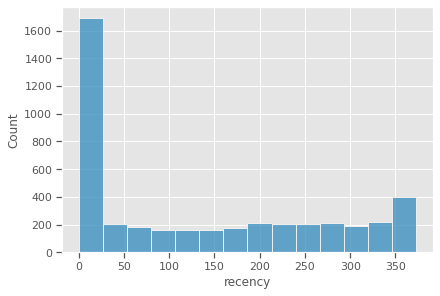

In [11]:
# The data is skewed to the right indicating the majority of customers placed only 1 order.

plt.figure(figsize=(6, 4), constrained_layout=True)
sns.histplot(df_rfm.recency)

plt.show()

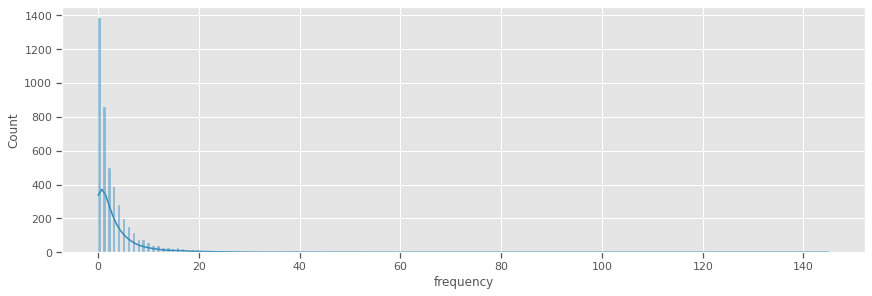

In [12]:
# the frequency of orders are also skewed, however, we have a few outliers with the requency over 100
plt.figure(figsize=(12, 4), constrained_layout=True)
sns.histplot(df_rfm.frequency, kde=True)

plt.show()

Age: the number of days between the FIRST purchase and the dataset last date.<br/>
The age distribution shows a decline among newer customers.
The peaks and troughs in the left side of the graph may indicate some sort of seasonality.

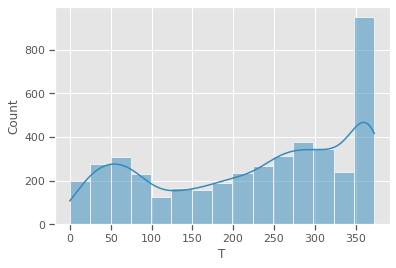

In [13]:
# plotting the Age distribution
sns.histplot(df_rfm['T'], kde=True)
plt.show()

#### 3.2 Fitting the BG/NBD model without Train_Test Split

Geometric/Negative Binomial Distribution (BG/NBD) model is derived from Pareto/NBD model for CLV.

Model assumptions:

- Each individual, i, has a hidden lambda_i and p_i parameter
- These come from a population wide Gamma and a Beta distribution respectively
- Individuals purchases follow a Poisson process with rate lambda_i*t
- After each purchase, an individual has a p_i probability of dying (never buying again)

In [14]:
# Fitting the BG/NBD model
# Eestimating model parameters (r, alpha, a and b) allows us to predict the expected number of transactions for users.

bgf = BetaGeoFitter(penalizer_coef=0) # penalizer_coef: The coefficient applied to an l2 norm on the parameters
bgf.fit(df_rfm['frequency'], df_rfm['recency'], df_rfm['T'])

# se(coef): standard error, and confidence intervals
bgf_summary_wo_split = bgf.summary
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.843025,0.026206,0.791661,0.894389
alpha,55.619383,2.088118,51.526671,59.712095
a,0.021519,0.006381,0.009012,0.034026
b,0.488673,0.176970,0.141812,0.835534


##### Recency Frequecy Matrix

Plotting expected transactions in T next units of time by a customer’s frequency (the number of repeat transactions by customer) and recency(age at last purchase).

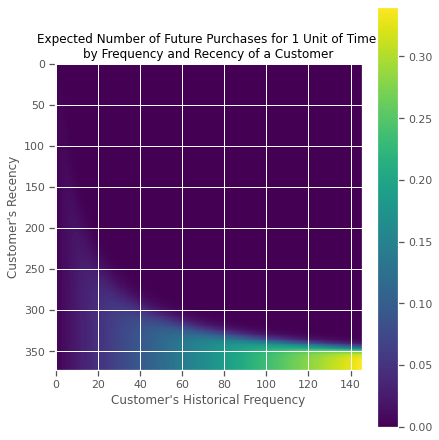

In [15]:
# The plot shows the most attractive segment of customers are those in the bottm right, meaning those with the recency of over 350 days ago and the frequncy of over 100

plt.figure(figsize=(6, 6), constrained_layout=True)
plot_frequency_recency_matrix(bgf)
plt.show()

##### Probability Alive Matrix

The probability plot shows us that as the recency and frequency increase, the chances of a customer to return grows.<br/>
So using startegies like email marketing or prmotional offers for these customers is more likely to result in a purchase

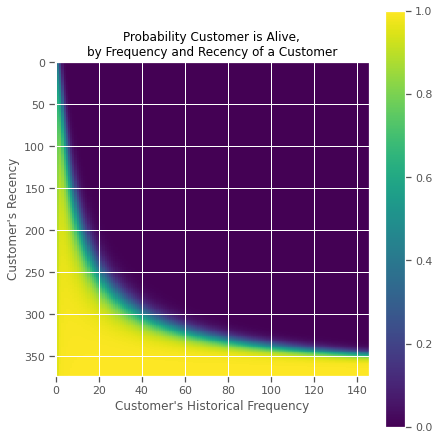

In [16]:
plt.figure(figsize=(6, 6), constrained_layout=True)
plot_probability_alive_matrix(bgf)
plt.show()

##### Customer Ranking

Predicted_purchases column calculates an estimate for the number of orders each customer in the dataset will make during the given time period<br/>
NOTE: At the customer individual level, the model can have a high variability, however, it can be used as a benchmark to select customers with higher monetary_value & predicted_purchases for e.g. promotional offers and customer retention campaigns

In [17]:
# Calculating future purchase baseline
num_of_days = 90

# Adding a column to rank customer from “highest expected purchases in the next period” to lowest
df_pred_wo_split = df_rfm.copy()
df_pred_wo_split['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(num_of_days, df_pred_wo_split['frequency'], df_pred_wo_split['recency'], df_pred_wo_split['T'])

# looking at the data, 
df_pred_wo_split.sort_values(by='predicted_purchases', ascending=False).head()

,frequency,recency,T,monetary_value,predicted_purchases
customer_id,,,,,
14911.0,145.0,372.0,373.0,910.463745,30.551950
12748.0,114.0,373.0,373.0,254.975006,24.058267
17841.0,112.0,372.0,373.0,355.421417,23.637824
15311.0,90.0,373.0,373.0,655.266785,19.029464
14606.0,88.0,372.0,373.0,130.858292,18.609342


In [18]:
# Now we can find purchase for a specific customer in 90 days:
customer_pred_wo_split = df_pred_wo_split.loc[12346:12348, 'predicted_purchases']
customer_pred_wo_split

customer_id
12346.0    0.197742
12347.0    1.447694
12348.0    0.818469
Name: predicted_purchases, dtype: float64

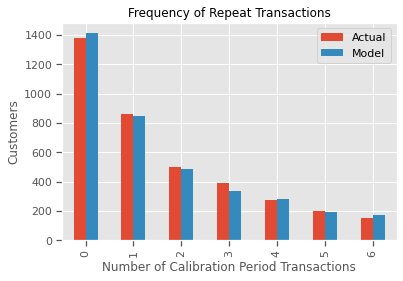

In [19]:
# The below chart allows us to check the accuracy of the model
plot_period_transactions(bgf)
plt.show()

#### 3.3 Fitting the BG/NBD model with Train_Test Split

lifetime has the capability to split the data into 2 partitions based on the date range for training (calibration) and testing (holdout).<br/>
This allows us to fit the model on calibration dataset and test it through the holdout dataset.<br/>
We use it to see how the model works on unseen data, but at the end we will train the model on all of the data, so we use df_pred_wo_split

In [20]:
# we have data for 9 months
df.order_date.min(), df.order_date.max()

(Timestamp('2010-12-01 08:26:00'), Timestamp('2011-12-09 12:50:00'))

In [21]:
# We split our data to first 8 months for calibration and 1 month for the holdout
summary_cal_holdout = calibration_and_holdout_data(df, 'customer_id', 'order_date', calibration_period_end='2011-08-10', observation_period_end='2011-09-09' )

# the transformed dataset is now partitioned to calibration period and houldout period ready to be fitted to the model 
summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
customer_id,,,,,
12346.0,0.0,0.0,204.0,0.0,30.0
12347.0,4.0,238.0,246.0,0.0,30.0
12348.0,2.0,110.0,237.0,0.0,30.0
12350.0,0.0,0.0,189.0,0.0,30.0
12352.0,3.0,34.0,175.0,0.0,30.0


In [22]:
# We fit the calibration columns to the model and test it on houldout columns

bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
bgf_summary_w_split = bgf.summary
bgf_summary_w_split

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.757904,0.029945,0.699211,0.816597
alpha,51.176757,2.471164,46.333276,56.020238
a,0.046096,0.015215,0.016275,0.075917
b,0.714177,0.283645,0.158233,1.270121


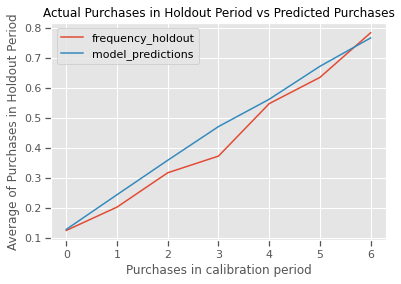

In [23]:
# now we can fit the holdouts to see the level of accuracy of teh fitted model
# the model has a hard time to estimate repeat purchases over 2

plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)
plt.show()

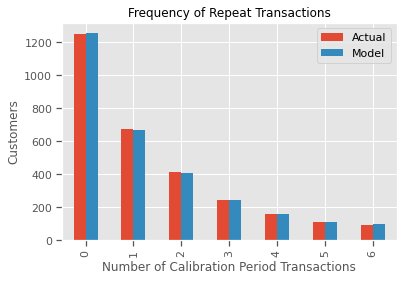

In [24]:
plot_period_transactions(bgf)
plt.show()

##### Customer Purchase Predictions

Using the model, we will be able to estimate future purchases by an individual customer. This allows us to pinpoint the likely best customers.

In [25]:
# customer_ids
df.customer_id.sort_values().unique()

array([12346., 12347., 12348., ..., 18282., 18283., 18287.], dtype=float32)

In [26]:
# expected number of purchases for the next 30 days
num_of_days = 90 

# we pull the customer rows from df_metrics which contains frequency, recency and age for each customer
individual = df_rfm.iloc[:3]

# passing the customer's frequency, recency and age to the model to get predictions
# bgf.predict() is alias for bgf.conditional_expected_number_of_purchases_up_to_time()
customer_pred_w_split = bgf.predict(num_of_days, individual['frequency'], individual['recency'], individual['T'])
customer_pred_w_split

customer_id
12346.0    0.179276
12347.0    1.434827
12348.0    0.792880
dtype: float64

In [27]:
# comparing the purchse perdictions for the model with and without train-test split
abs(customer_pred_wo_split.sub(customer_pred_w_split))

customer_id
12346.0    0.018466
12347.0    0.012867
12348.0    0.025589
dtype: float64

In [28]:
# comparing summaries of the model with and without train_test split
bgf_summary_wo_split

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.843025,0.026206,0.791661,0.894389
alpha,55.619383,2.088118,51.526671,59.712095
a,0.021519,0.006381,0.009012,0.034026
b,0.488673,0.176970,0.141812,0.835534


In [29]:
# we have higher errors with split since some of the data is set aside as a holdout which the model don't get the chance to train on.
bgf_summary_w_split

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.757904,0.029945,0.699211,0.816597
alpha,51.176757,2.471164,46.333276,56.020238
a,0.046096,0.015215,0.016275,0.075917
b,0.714177,0.283645,0.158233,1.270121


##### Model tuning

We can perform model tuning on penalizer coef whcih we skip in this notebook.

In [30]:
# selecting the final model
bgf_final = bgf
df_pred_final = df_pred_wo_split

#### Customer Probability History

Customer probability history allows to examine the customer purchase latency and see the likelihood of churn based on their historical transactions.<br/>
When customers are alive (likely to return), we assume they will purchase somewhere around the mean of their mean transaction rate randomly. So if the mean transaction rate for a customer is every 10 days, we may see orders from them on day 7 or 14 for example.
In that case, it helps us to see the probability of churn if the customer hasn't purchased after 10 days from their last purchase and for example send them a promo email to persuade them to return.

In [31]:
df_rfm.loc[17888]

frequency           8.000000
recency           339.000000
T                 357.000000
monetary_value     62.043747
Name: 17888.0, dtype: float64

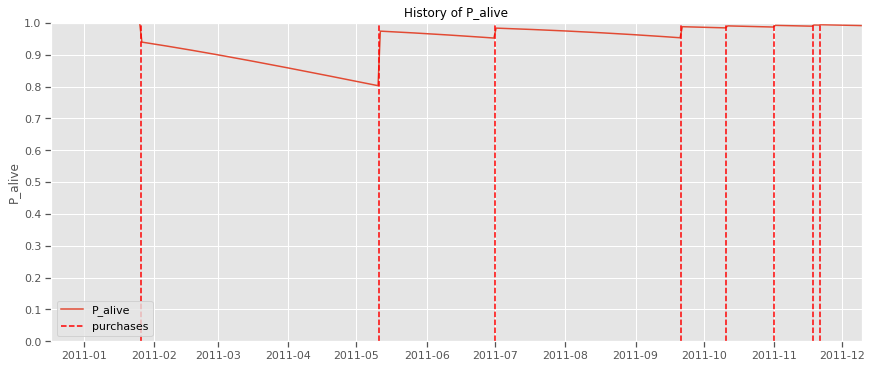

In [32]:
# Selecting a customer to plot
id_of_customer = 17888

# calculating the age of the customer (df_metrics.loc[17888, 'T'])
days_since_birth = (df.order_date.max() - df.loc[df.customer_id == id_of_customer, 'order_date'].min()).days + 1

sp_trans = df.loc[df['customer_id'] == id_of_customer]

plt.figure(figsize=(12, 5), constrained_layout=True)
plot_history_alive(bgf_final, days_since_birth, sp_trans, 'order_date')
plt.show()

### 4. Estimating Customer Lifetime Value (CLV)

#### 4.1 Gamma-Gamma model to predict customers monetary values

##### Preparing data

NOTE: monetary value in df_rfm is the mean of a given customer’s order value, not the sum. <br/>
It assumes that the monetary value of a customer’s transactions will vary randomly around their mean order value

In [33]:
# we calculate customer value only for repeat customers
# to remove order returns (with negative value), we also filter for monetary_value > 0
df_returning_customers = df_rfm.loc[(df_rfm.frequency > 0) & (df_rfm.monetary_value > 0)]
df_returning_customers.head()

,frequency,recency,T,monetary_value
customer_id,,,,
12347.0,6.0,365.0,367.0,599.701660
12348.0,3.0,283.0,358.0,301.479980
12352.0,6.0,260.0,296.0,208.151672
12356.0,2.0,303.0,325.0,269.904999
12358.0,1.0,149.0,150.0,683.200012


##### Fitting Gamma-Gamma model 

Checking corrolation

We use Gamma-Gamma submodel to estimate the CLV.<br/>
This model assumes that there is no relationship between the monetary value and the purchase frequency.<br/>
To verify that, we need to check if there is a corrolation between frequency and value.<br/>
Pearson's r between the two vectors should be close to 0 for this model to work.<br/>

In [34]:
# calculating the correlation coefficient
df_returning_customers.frequency.corr(df_returning_customers.monetary_value)

0.17498384283815258

Fitting the model

Since there is no strong corrolation between frequency and value, we can use the model.<br/>
If we have the profit amount per customer, we can use that instead of feeding the df_returning_customers['monetary_value'] to the model. For that, we should use the mean profit for each customer.

In [35]:
# fitting frequency & monetary_value from df_rfm
ggf = ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(df_returning_customers['frequency'], df_returning_customers['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 2796 subjects, p: 1.60, q: 3.59, v: 553.51>

In [36]:
# shape, scale, variance parameters
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,1.595452,0.083753,1.431297,1.759608
q,3.585610,0.156889,3.278107,3.893112
v,553.507650,50.839851,453.861542,653.153759


##### Predicting Average Order Value per customer (AOV)

Now the model can predict average monetary_value per customer

In [37]:
# ggf returns Expected average monetary_value for repeat customers using a gamma distribution

aov = ggf.conditional_expected_average_profit(df_returning_customers['frequency'], df_returning_customers['monetary_value'])
df_aov = aov.to_frame().reset_index().rename(columns={0: 'aov'}).sort_values(by='aov', ascending=False)

df_aov

,customer_id,aov
2710,18102.0,8365.912129
34,12415.0,6297.729570
1111,14646.0,5879.209757
2416,17450.0,5532.523750
2045,16684.0,3528.687797
...,...,...
1073,14560.0,102.540000
170,12679.0,94.902500
1331,15107.0,89.909790
2680,18037.0,89.452097


#### 4.2 Predicting expected number of orders per customer using BG/NBD

The gbf model we fit before was fitted on the whole data set. However, for calculating CLV, we need to fit to recurring customers only.

In [38]:
# we also already know the best penalizer_coef when we fit it to the whole dataset -> we use that coef here

bgf_clv = BetaGeoFitter(penalizer_coef=0)
bgf_clv.fit(df_returning_customers['frequency'], df_returning_customers['recency'], df_returning_customers['T'])

# se(coef): standard error, and confidence intervals
bgf_clv_summary = bgf_clv.summary
bgf_clv.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,1.844145,0.065123,1.716504,1.971786
alpha,87.624237,3.442928,80.876097,94.372376
a,0.032423,0.008922,0.014936,0.049910
b,1.001674,0.357713,0.300558,1.702791


In [39]:
bgf_clv

<lifetimes.BetaGeoFitter: fitted with 2796 subjects, a: 0.03, alpha: 87.62, b: 1.00, r: 1.84>

#### 4.3 Predicting CLV per customer using gamma-gamma model

Now that we have bgf_clv for repeat customers, we use that along with returning customers rfm to get clv prediction from the trained gamma model on returning customers.<br/>
NOTE: the model uses Discounted cash flow (DCF) method to calculate the Net Present Value (NPV) of future purchases
and for that it needs an input for time parameter (how long in the future we are calculating the CLV for) 
and the monthly adjusted discount rate r for the cost of capital. The default value for r is 0.01.

In [40]:
# calculating CLV for 12 months at the discount_rate of 0.07
clv_pred = ggf.customer_lifetime_value(
    bgf,
    df_returning_customers['frequency'],
    df_returning_customers['recency'],
    df_returning_customers['T'],
    df_returning_customers['monetary_value'],
    time = 12,
    discount_rate = 0.07
)

# creating a df for the CLV predictions
df_clv = clv_pred.to_frame().reset_index().sort_values(by='clv', ascending=False)

In [41]:
# High value customers
df_clv.head()

,customer_id,clv
1111,14646.0,159162.874287
2710,18102.0,125519.917368
2416,17450.0,101533.989594
834,14096.0,82856.448806
1245,14911.0,72987.617064


In [42]:
# low value customers
df_clv.tail()

,customer_id,clv
1965,16499.0,49.322926
368,13093.0,44.197451
2068,16725.0,40.043800
1325,15100.0,6.985973
1331,15107.0,5.215296


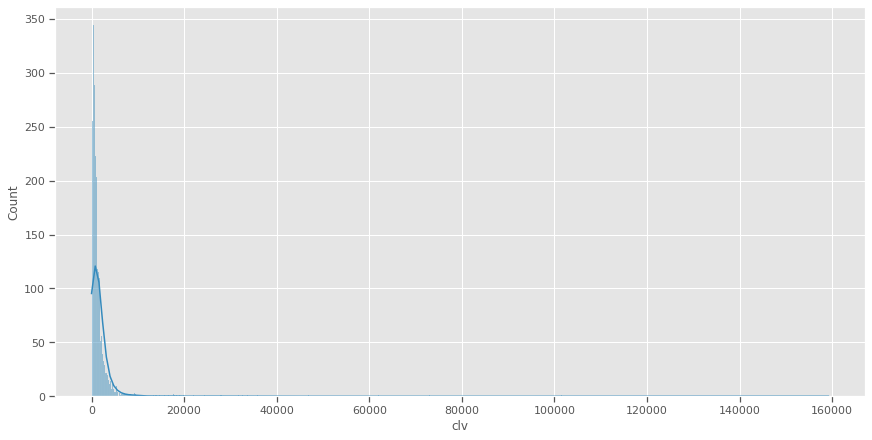

In [43]:
plt.figure(figsize=(12, 6), constrained_layout=True)
sns.histplot(df_clv.clv, kde=True)

plt.show()

### 5. Segmenting repeat customers based on CLV

There is a strong corrolation between Average Order Value (AOV) and CLV since CLV also takes into account both the AOV and probability of churn. For that reason, for segmentation, we only need to use one of them which will be CLV

In [44]:
# corroloation between AOV and CLV
df_aov.aov.corr(df_clv.clv)

0.8105231447879293

In [45]:
df_clv.clv.describe().round()

count      2796.0
mean       1747.0
std        5628.0
min           5.0
25%         503.0
50%         898.0
75%        1611.0
max      159163.0
Name: clv, dtype: float64

#### Bucket Segmentation

In [46]:
# function to return some descreptives about segmented data
def describe_clv(df):
    df_clv_info = df.groupby('segment').agg(total_value = ('clv', 'sum'), customer_count=('clv', 'count'), clv_mean=('clv', 'mean'), clv_median=('clv', 'median'), clv_max=('clv', 'max'), clv_min=('clv', 'min'), clv_std=('clv', 'std'))
    df_clv_info['value_pct'] = df_clv_info.total_value.div(df_clv_info.total_value.sum()).mul(100)
    df_clv_info['count_pct'] = df_clv_info.customer_count.div(df_clv_info.customer_count.sum()).mul(100)
    df_clv_info['range'] = df_clv_info.clv_max.sub(df_clv_info.clv_min)

    df_clv_info = df_clv_info.round()
    df_clv_info = df_clv_info[['customer_count', 'count_pct', 'total_value', 'value_pct', 'clv_mean', 'clv_median', 'clv_min', 'clv_max', 'range', 'clv_std']]

    return df_clv_info

##### Segmentation using quantiles

In [47]:
# we segment the customers to 5 quantiles to have approximately 20% of customers in each bucket
quantiles = 5
pd.qcut(df_clv.clv, q=quantiles, precision=0).value_counts()

(4.0, 438.0]          560
(438.0, 713.0]        559
(713.0, 1112.0]       559
(1112.0, 1855.0]      559
(1855.0, 159163.0]    559
Name: clv, dtype: int64

In [48]:
# we add a column to df_clv to segment the customers based on their quantiles
df_clv_q = df_clv.copy()
df_clv_q['segment'] = pd.qcut(df_clv_q.clv, q=quantiles, precision=0, labels=list(range(1, quantiles+1)))
df_clv_q.set_index('customer_id', drop=True, inplace=True)

df_clv_q.head()

,clv,segment
customer_id,,
14646.0,159162.874287,5
18102.0,125519.917368,5
17450.0,101533.989594,5
14096.0,82856.448806,5
14911.0,72987.617064,5


In [49]:
describe_clv(df_clv_q)

,customer_count,count_pct,total_value,value_pct,clv_mean,clv_median,clv_min,clv_max,range,clv_std
segment,,,,,,,,,,
1,560,20.0,170125.0,3.0,304.0,309.0,5.0,438.0,433.0,89.0
2,559,20.0,320455.0,7.0,573.0,571.0,438.0,713.0,274.0,80.0
3,559,20.0,503657.0,10.0,901.0,898.0,714.0,1112.0,397.0,113.0
4,559,20.0,804057.0,16.0,1438.0,1427.0,1112.0,1855.0,743.0,211.0
5,559,20.0,3086123.0,63.0,5521.0,2933.0,1858.0,159163.0,157305.0,11834.0


##### Segmentation using custom bins

In [50]:
# we segment the customers to 5 groups
clv_bins = [0, 1000, 2000, 5000, 12000, max(df_clv.clv)]
pd.cut(df_clv.clv, bins=clv_bins, precision=0).value_counts()

(0.0, 1000.0]          1545
(1000.0, 2000.0]        750
(2000.0, 5000.0]        391
(5000.0, 12000.0]        77
(12000.0, 159163.0]      33
Name: clv, dtype: int64

In [51]:
# we add a column to df_clv to segment the customers based on their bins
df_clv_b = df_clv.copy()
df_clv_b['segment'] = pd.cut(df_clv.clv, bins=clv_bins, precision=0, labels=list(range(1, len(clv_bins))))
df_clv_b.set_index('customer_id', drop=True, inplace=True)

df_clv_b.head()

,clv,segment
customer_id,,
14646.0,159162.874287,5
18102.0,125519.917368,5
17450.0,101533.989594,5
14096.0,82856.448806,5
14911.0,72987.617064,5


In [52]:
describe_clv(df_clv_b)

,customer_count,count_pct,total_value,value_pct,clv_mean,clv_median,clv_min,clv_max,range,clv_std
segment,,,,,,,,,,
1,1545,55.0,854221.0,17.0,553.0,533.0,5.0,1000.0,994.0,234.0
2,750,27.0,1055771.0,22.0,1408.0,1358.0,1000.0,1998.0,998.0,278.0
3,391,14.0,1167635.0,24.0,2986.0,2802.0,2003.0,4988.0,2986.0,768.0
4,77,3.0,542457.0,11.0,7045.0,6609.0,5038.0,11635.0,6597.0,1834.0
5,33,1.0,1264333.0,26.0,38313.0,24501.0,13500.0,159163.0,145663.0,34789.0


#### K-means customer segmentation

In [53]:
df_clv.set_index('customer_id', inplace=True)
df_clv_kmeans = df_clv.copy()

Calculating the optimal number of clusters for segmentation

In [54]:
# calculating k-means inertia for differnet cluster numbers for elbow method
def kmeans_k(k, df):

    ssd = []
    for i in range(2, k+1):
        kmeans_model = KMeans(n_clusters=i, init='k-means++', max_iter=500, random_state=100)
        kmeans_model.fit(df)
        ssd.append(kmeans_model.inertia_)

    return ssd

Plotting the elbow method

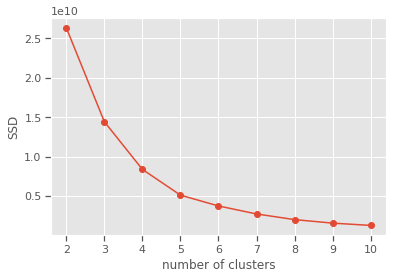

In [55]:
# plotting inertia against the k values
# k=5 seems to be the best k
k =10

plt.plot(np.arange(2, k+1), kmeans_k(k, df_clv_kmeans), marker='o')
plt.xlabel('number of clusters')
plt.ylabel('SSD')
plt.show()

Fitting the model

In [56]:
# NOTE: No need for scaling since we are using only 1 column

kmeans_model = KMeans(n_clusters=5, init='k-means++', max_iter=500, random_state=100)
cluster_labels = kmeans_model.fit_predict(df_clv_kmeans)
df_clv_kmeans['segment'] = pd.Series(cluster_labels, index=df_clv_kmeans.index)
df_clv_kmeans.head()

,clv,segment
customer_id,,
14646.0,159162.874287,2
18102.0,125519.917368,2
17450.0,101533.989594,1
14096.0,82856.448806,1
14911.0,72987.617064,1


In [57]:
# NOTE: KMeans is sensitive to outliers
describe_clv(df_clv_kmeans).sort_values(by='clv_max')

,customer_count,count_pct,total_value,value_pct,clv_mean,clv_median,clv_min,clv_max,range,clv_std
segment,,,,,,,,,,
0,2498,89.0,2391822.0,49.0,957.0,794.0,5.0,2828.0,2822.0,622.0
4,268,10.0,1269636.0,26.0,4737.0,3965.0,2836.0,14039.0,11203.0,2115.0
3,23,1.0,551830.0,11.0,23993.0,22180.0,14720.0,46795.0,32075.0,8057.0
1,5,0.0,386446.0,8.0,77289.0,72988.0,62042.0,101534.0,39492.0,15613.0
2,2,0.0,284683.0,6.0,142341.0,142341.0,125520.0,159163.0,33643.0,23789.0
